In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score

from sklearn.ensemble import GradientBoostingClassifier

## plot size
plt.rcParams.update({'figure.figsize':(15,6)})
plt.rcParams.update({'font.size':18})

In [2]:
# importing the dataset
df = pd.read_csv("Churn_Modelling.csv")

# trimming the Age varibale
df = df[df["Age"]<=75].reset_index()

# creating dummy variables
dum = pd.get_dummies(df[['Geography','Gender']],drop_first=True)
df['Geography_Germany'] = dum['Geography_Germany']
df['Geography_Spain'] = dum['Geography_Spain']
df['Gender_Male'] = dum['Gender_Male']

# using the KNN Imputer for the Balance variable
df['Balance_nan'] = df['Balance'].replace(0.00, np.nan)
knn_df = df[['CreditScore','Age', 'Tenure', 'Balance_nan','EstimatedSalary','Gender_Male']]
imputer = KNNImputer(n_neighbors=10, weights="distance")
knn_df = imputer.fit_transform(knn_df)
knn_df = pd.DataFrame(knn_df,columns =['CreditScore','Age', 'Tenure', 'Balance_nan','EstimatedSalary','Gender_Male'])

df_keep = df[[ 'Exited','CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male']].reset_index()
df_keep = df_keep.drop("index",axis=1)
df_with_knn = df_keep.copy()
df_with_knn['Balance'] = knn_df['Balance_nan']

In [3]:
df_with_knn

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,1,619,42,2,137971.483371,1,1,1,101348.88,0,0,0
1,0,608,41,1,83807.860000,1,0,1,112542.58,0,1,0
2,1,502,42,8,159660.800000,3,1,0,113931.57,0,0,0
3,0,699,39,1,133585.075460,2,0,0,93826.63,0,0,0
4,0,850,43,2,125510.820000,1,1,1,79084.10,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9950,0,771,39,5,144541.517907,2,1,0,96270.64,0,0,1
9951,0,516,35,10,57369.610000,1,1,1,101699.77,0,0,1
9952,1,709,36,7,132552.368184,1,0,1,42085.58,0,0,0
9953,1,772,42,3,75075.310000,2,1,0,92888.52,1,0,1


In [4]:
# dataframe with using knn on the balance
X_knn = df_with_knn.drop("Exited",axis=1)
y_knn = df_with_knn["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.25, stratify=y_knn)

In [5]:
scale=StandardScaler()
train=scale.fit_transform(X_train)
test=scale.transform(X_test)

### Best Model

In [6]:
# XG-Boost Model
xgb = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, max_features = 'sqrt', n_estimators = 200).fit(train, y_train)
y_pred = xgb.predict(test)
print(f'The classification rate is {round(accuracy_score(y_test, y_pred),4)}')

The classification rate is 0.8662


[0.03723726 0.3754056  0.00786005 0.06701334 0.2993167  0.00141989
 0.09123812 0.02654592 0.0642855  0.00548406 0.02419357]


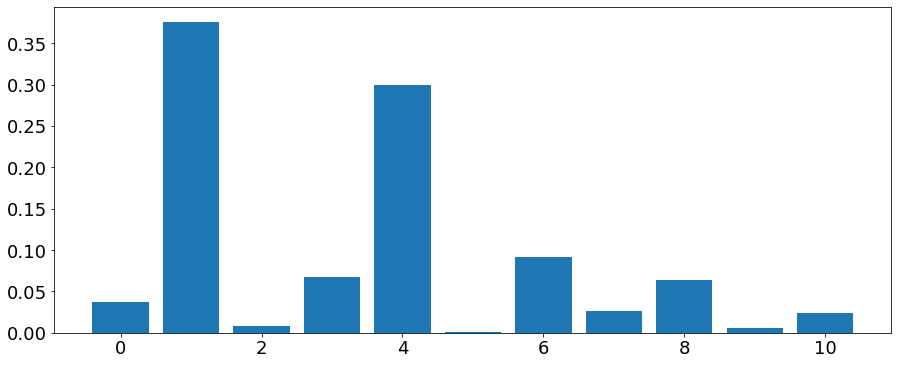

In [7]:
# feature importance
print(xgb.feature_importances_)
# plot
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

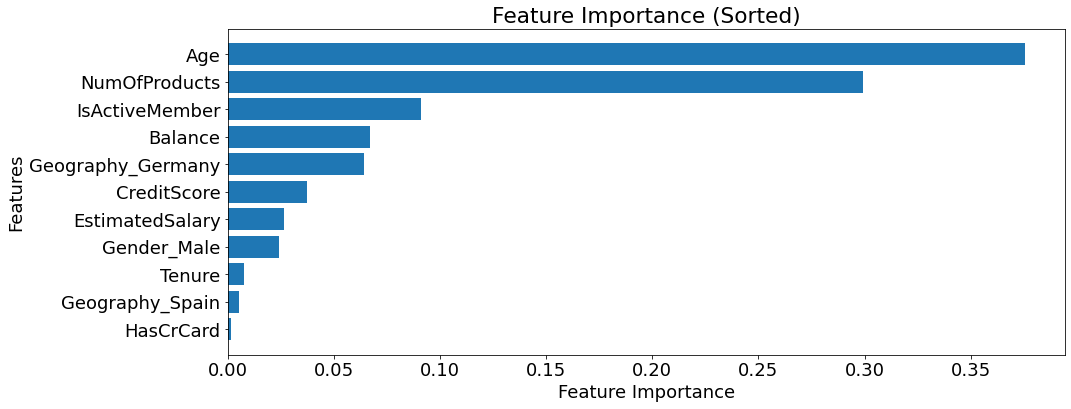

In [8]:
importances = xgb.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])
plt.title('Feature Importance (Sorted)')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

### Misclassified Labels

In [9]:
y_table = y_test.to_frame()
y_table['y_pred'] = y_pred
y_table

,Exited,y_pred
3942,0,0
1452,0,0
4042,0,0
1563,1,1
3659,0,0
...,...,...
6798,1,1
438,0,0
9063,0,0
7846,0,0


In [10]:
mis_clas = y_table[y_table.Exited != y_table.y_pred]
mis_clas

,Exited,y_pred
695,1,0
1857,1,0
4198,1,0
139,1,0
7703,1,0
...,...,...
9740,0,1
9611,1,0
9089,1,0
3758,0,1


In [11]:
# dividing the dataset into False Positive & False Negative
FP = mis_clas[mis_clas.y_pred == 1]
FN = mis_clas[mis_clas.y_pred == 0]

### Deep Dive into the False Positives

In [12]:
FP

,Exited,y_pred
6026,0,1
7092,0,1
7592,0,1
1529,0,1
1318,0,1
...,...,...
5750,0,1
376,0,1
9740,0,1
3758,0,1


In [13]:
FP.index

Int64Index([6026, 7092, 7592, 1529, 1318, 7598, 2555, 6957, 8517, 1650, 6092,
            9612, 5573, 8992, 5317,  140, 1786, 2414, 4674, 6175, 1635, 3933,
            4751, 3876,  382, 6324, 9028, 2586, 9536, 6580, 5022, 2738, 5233,
            3639, 2354, 9147, 5755, 5701, 8159, 9297, 6045, 2816, 4744, 2562,
            8639, 5089,  607, 7981, 5464, 5875, 7335, 8239, 8002, 9582,  975,
             162, 4438, 2904, 1542, 1231, 6415, 7176, 1503, 6669, 8810, 7561,
            6157, 2944, 6765, 6168, 7769, 5108, 4295, 6344, 9005, 4150, 7230,
            5750,  376, 9740, 3758, 3257],
           dtype='int64')

In [14]:
FP_df = df_with_knn[df_with_knn.index.isin(FP.index)]

/Users/yamato0615/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='CreditScore'>

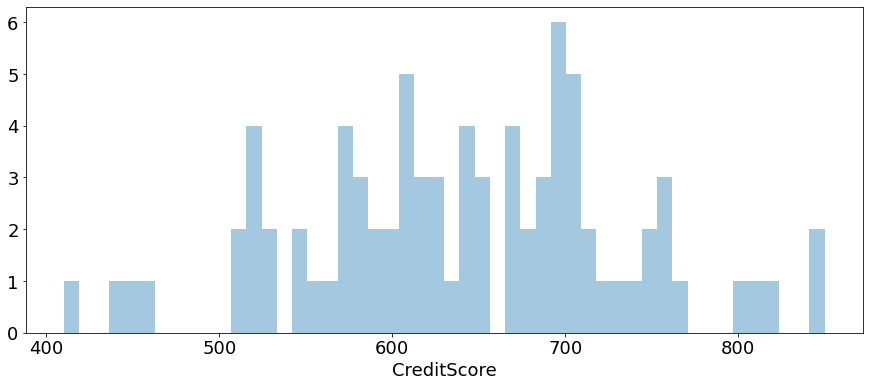

In [15]:
sns.distplot(FP_df['CreditScore'],bins=50, kde=False)

<AxesSubplot:xlabel='CreditScore', ylabel='count'>

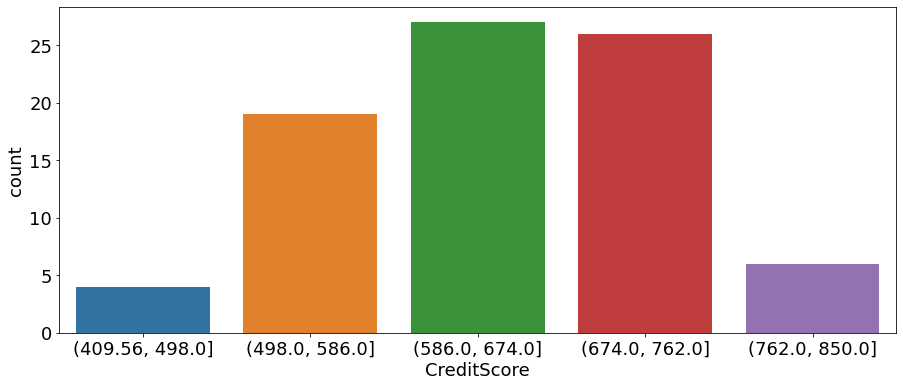

In [16]:
Cat_Age=pd.cut(x=FP_df["CreditScore"],bins=5)
sns.countplot(x=Cat_Age)

<AxesSubplot:xlabel='Age'>

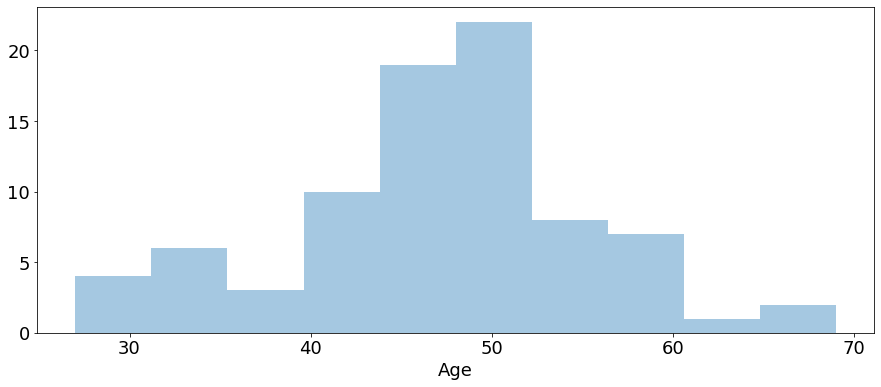

In [17]:
sns.distplot(FP_df['Age'],bins=10, kde=False)

<AxesSubplot:xlabel='Tenure'>

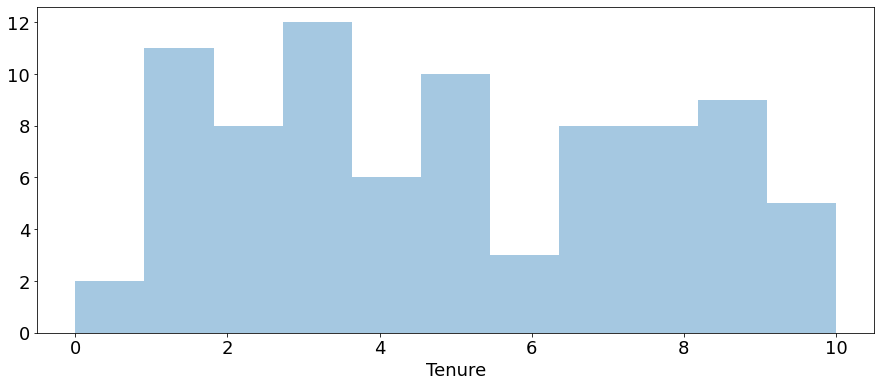

In [18]:
sns.distplot(FP_df['Tenure'],bins=11, kde=False)

### Deep Dive into the False Negatives

<AxesSubplot:xlabel='CreditScore'>

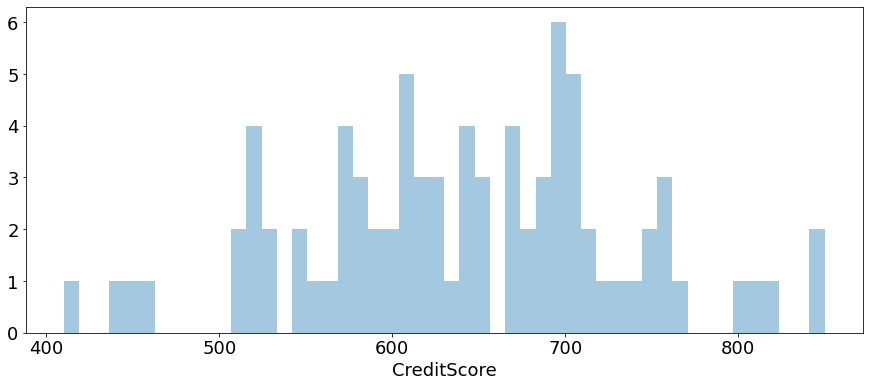

In [19]:
FN_df = df_with_knn[df_with_knn.index.isin(FN.index)]
sns.distplot(FP_df['CreditScore'],bins=50, kde=False)

<AxesSubplot:xlabel='CreditScore', ylabel='count'>

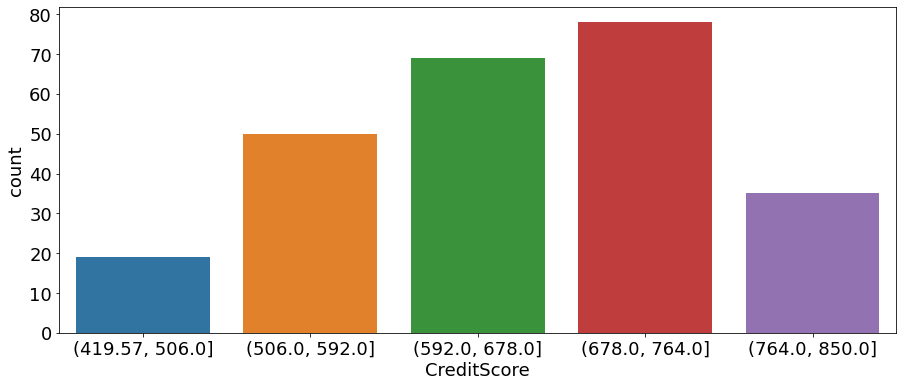

In [20]:
Cat_Age=pd.cut(x=FN_df["CreditScore"],bins=5)
sns.countplot(x=Cat_Age)

<AxesSubplot:xlabel='Age'>

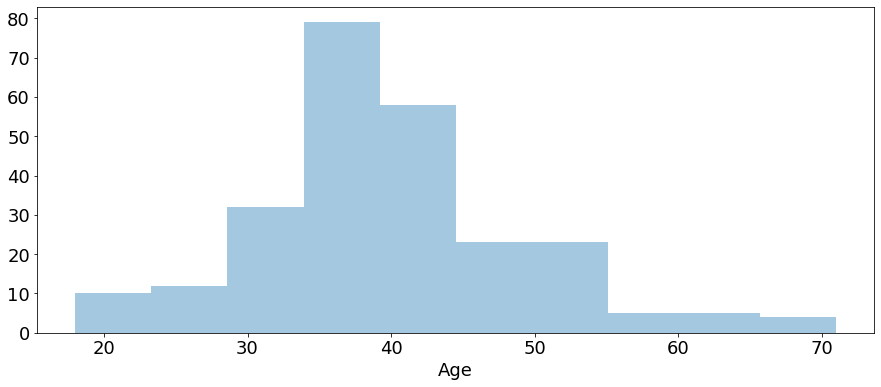

In [21]:
sns.distplot(FN_df['Age'],bins=10, kde=False)

<AxesSubplot:xlabel='Tenure'>

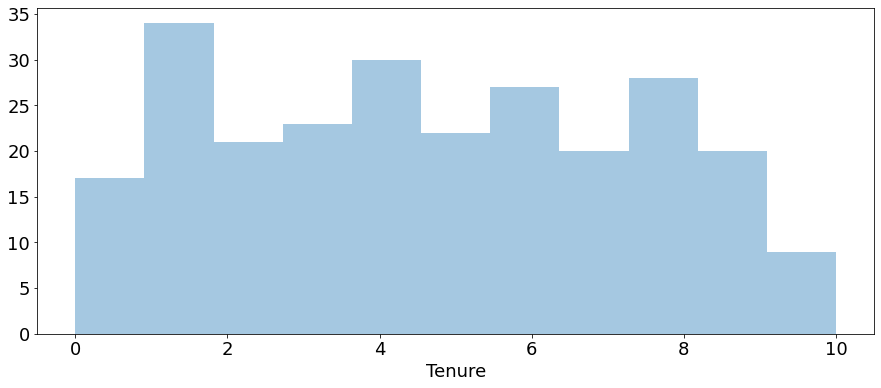

In [23]:
sns.distplot(FN_df['Tenure'],bins=11, kde=False)